use python3

# Preamble

In [2]:
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import xarray as xr
import pandas as pd
import numpy as np

from Ocean_Coordinates import choose_region

In [3]:
def derivatives(new_grid, unmasked_unvalid_input_data):
    vxyz = xr.concat([new_grid.cartesian_x_vertices, new_grid.cartesian_y_vertices, new_grid.cartesian_z_vertices], dim="xyz")
    cxyz = xr.concat([new_grid.cell_circumcenter_cartesian_x, new_grid.cell_circumcenter_cartesian_y, new_grid.cell_circumcenter_cartesian_z], dim="xyz")

    def norm(da, dim):
        axis = da.dims.index(dim)
        resulting_dims = tuple(d for d in da.dims if d != dim)
        return xr.DataArray(np.linalg.norm(da.values, axis=axis), dims=resulting_dims)

    def normalize(da, dim):
        return da / norm(da, dim)

    north      = xr.DataArray([0., 0., 1.], dims=("xyz",))
    cell_up    = cxyz
    cell_east  = normalize(xr.cross(north, cell_up, dim="xyz"), "xyz")
    cell_north = normalize(xr.cross(cell_up, cell_east, dim="xyz"), "xyz")

    local_orientation = xr.concat([cell_east, cell_north, cell_up], dim="enu")

    neighbors_mask  = (new_grid.neighbor_cell_index.T - 1)
    valid_mask      = np.all(neighbors_mask>=0, axis=-1)
    
    dxyz       = (cxyz.drop_vars("cell").isel(cell=neighbors_mask[valid_mask]) - cxyz[:,valid_mask]) * new_grid.attrs["sphere_radius"]
    denu       = xr.dot(local_orientation[:,:,valid_mask], dxyz, dims="xyz")

    de, dn, du = denu.transpose("enu", "cell", "nv").values
    ones       = np.ones_like(de)
    A          = np.stack((ones, de, dn), axis=-1)  # cells, neighbors, oll
    A_inv      = np.linalg.inv(A)
    
    print('A_inv.shape:', A_inv.shape)
    varibale_0, dvariable_dx, dvariable_dy = np.einsum('...ij,...j->i...', A_inv, unmasked_unvalid_input_data[...,neighbors_mask[valid_mask]])
    
    return varibale_0, dvariable_dx, dvariable_dy, valid_mask

In [4]:
def zonal_mean_2nd_derivative(variable, new_grid, bins):
    counts_per_bin, lat_bins = np.histogram(new_grid.clat, bins=bins)
    varsum_per_bin, _ = np.histogram(new_grid.clat, weights=variable, bins=bins)
    zonal_mean = varsum_per_bin / counts_per_bin
    return zonal_mean, lat_bins

In [5]:
def dpdz(p, z, g, R, SST, c_p, H0):
    return -(p * g) / (R * ( SST - 0.5 - (g*z)/c_p) )

# Composite trapezoidal rule for numerical integration
def trapezoidal_rule(p_initial, z_values, dz, g, R_values, SST, c_p, H0):
    p_values = [p_initial]

    for i in range(1, len(z_values)):
        # Update the temperature and R_d for each integration step
        z_current = z_values[i - 1]
        R_current = R_values[i - 1,:]

        # Update pressure using the composite trapezoidal rule
        p_new = p_values[-1] + 0.5 * ( dpdz(p_values[-1], z_current, g, R_current, SST, c_p, H0) + dpdz(p_values[-1] + dpdz(p_values[-1], z_current, g, R_current, SST, c_p, H0) * dz[i], z_values[i], g, R_values[i], SST, c_p, H0)) * dz[i]
        p_values.append(p_new)

    return p_values

In [6]:
import re

def increment_number_in_string(input_string):
    # Use regular expression to find the number in the string
    pattern = r'\d+'
    match = re.search(pattern, input_string)

    if match:
        # Extract the matched number
        number_str = match.group(0)
        # Convert it to an integer, increment by 1, and convert it back to a string
        incremented_number = str(int(number_str) + 1)

        # Replace the matched number with the incremented number in the original string
        result_string = re.sub(pattern, incremented_number, input_string, count=1)
        return result_string
    else:
        # If no number was found in the string, return the original string
        return input_string

In [7]:
def cut_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(cell=indices.cell, vertex=indices.vertex, edge=indices.edge)
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype='int')
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid

In [8]:
def coriolis(reference_lat):   
    #siderial day in seconds: 86.164,0989 (source: Wikipedia)
    omega = 2 * np.pi / 86164.0989 #[1/s]
    return 2*omega*np.sin(np.deg2rad(reference_lat))

In [9]:
#OCEAN_TYPES = ['atlantic', 'western_pacific', 'central_pacific', 'eastern_pacific', 'indian_ocean']
#SEASONS = ['MAM', 'JJA', 'SON', 'DJF']
#YEARS = ['2020', '2021', '2022']
#DPP    = 'ngc2009'

In [10]:
OCEAN_TYPES = ['atlantic']#, 'western_pacific', 'central_pacific', 'eastern_pacific', 'indian_ocean']
SEASONS = ['MAM', 'JJA', 'SON', 'DJF']
YEARS = ['2020', '2021', '2022']
DPP    = 'ngc2009'

! Until here the code has to be run 2 times.

! One time for OCEAN_TYPE = 'atlantic' and a second time for OCEAN_TYPE = 'western_pacific'

#
#
#

# Loading Data

In [11]:
datapath = "/work/mh0731/m300868/00_DATA/Paper_Data_Revised/"
ZONAL_BINS = 50

In [12]:
YEAR = '2020'

In [13]:
OCEAN_1 = 'western_pacific'
SEASON_1 = 'MAM'

ZM_uu_wind_icon_orig_wpcf = np.load(datapath+f'fig_08_data/{OCEAN_1}/08_fig_ZM_uu_wind_icon_orig_{OCEAN_1}_{YEAR}_{SEASON_1}.npy')
ZM_uu_RFM_wpcf            = np.load(datapath+f'fig_08_data/{OCEAN_1}/08_fig_ZM_uu_RFM_{OCEAN_1}_{YEAR}_{SEASON_1}.npy')
ZM_uu_wind_revised_wpcf   = np.load(datapath+f'fig_08_data/{OCEAN_1}/08_fig_ZM_uu_wind_revised_{OCEAN_1}_{YEAR}_{SEASON_1}.npy')

In [14]:
OCEAN_2 = 'atlantic'
SEASON_2 = 'SON'

ZM_vv_wind_icon_orig_atl = np.load(datapath+f'fig_08_data/{OCEAN_2}/08_fig_ZM_vv_wind_icon_orig_{OCEAN_2}_{YEAR}_{SEASON_2}.npy')
ZM_vv_RFM_atl            = np.load(datapath+f'fig_08_data/{OCEAN_2}/08_fig_ZM_vv_RFM_{OCEAN_2}_{YEAR}_{SEASON_2}.npy')
ZM_vv_wind_revised_atl   = np.load(datapath+f'fig_08_data/{OCEAN_2}/08_fig_ZM_vv_wind_revised_{OCEAN_2}_{YEAR}_{SEASON_2}.npy')

# Plotting

In [15]:
SIZE = 25
plt.rcParams['axes.labelsize']  = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['xtick.labelsize'] = SIZE
plt.rcParams['ytick.labelsize'] = SIZE
plt.rcParams['font.size']       = SIZE

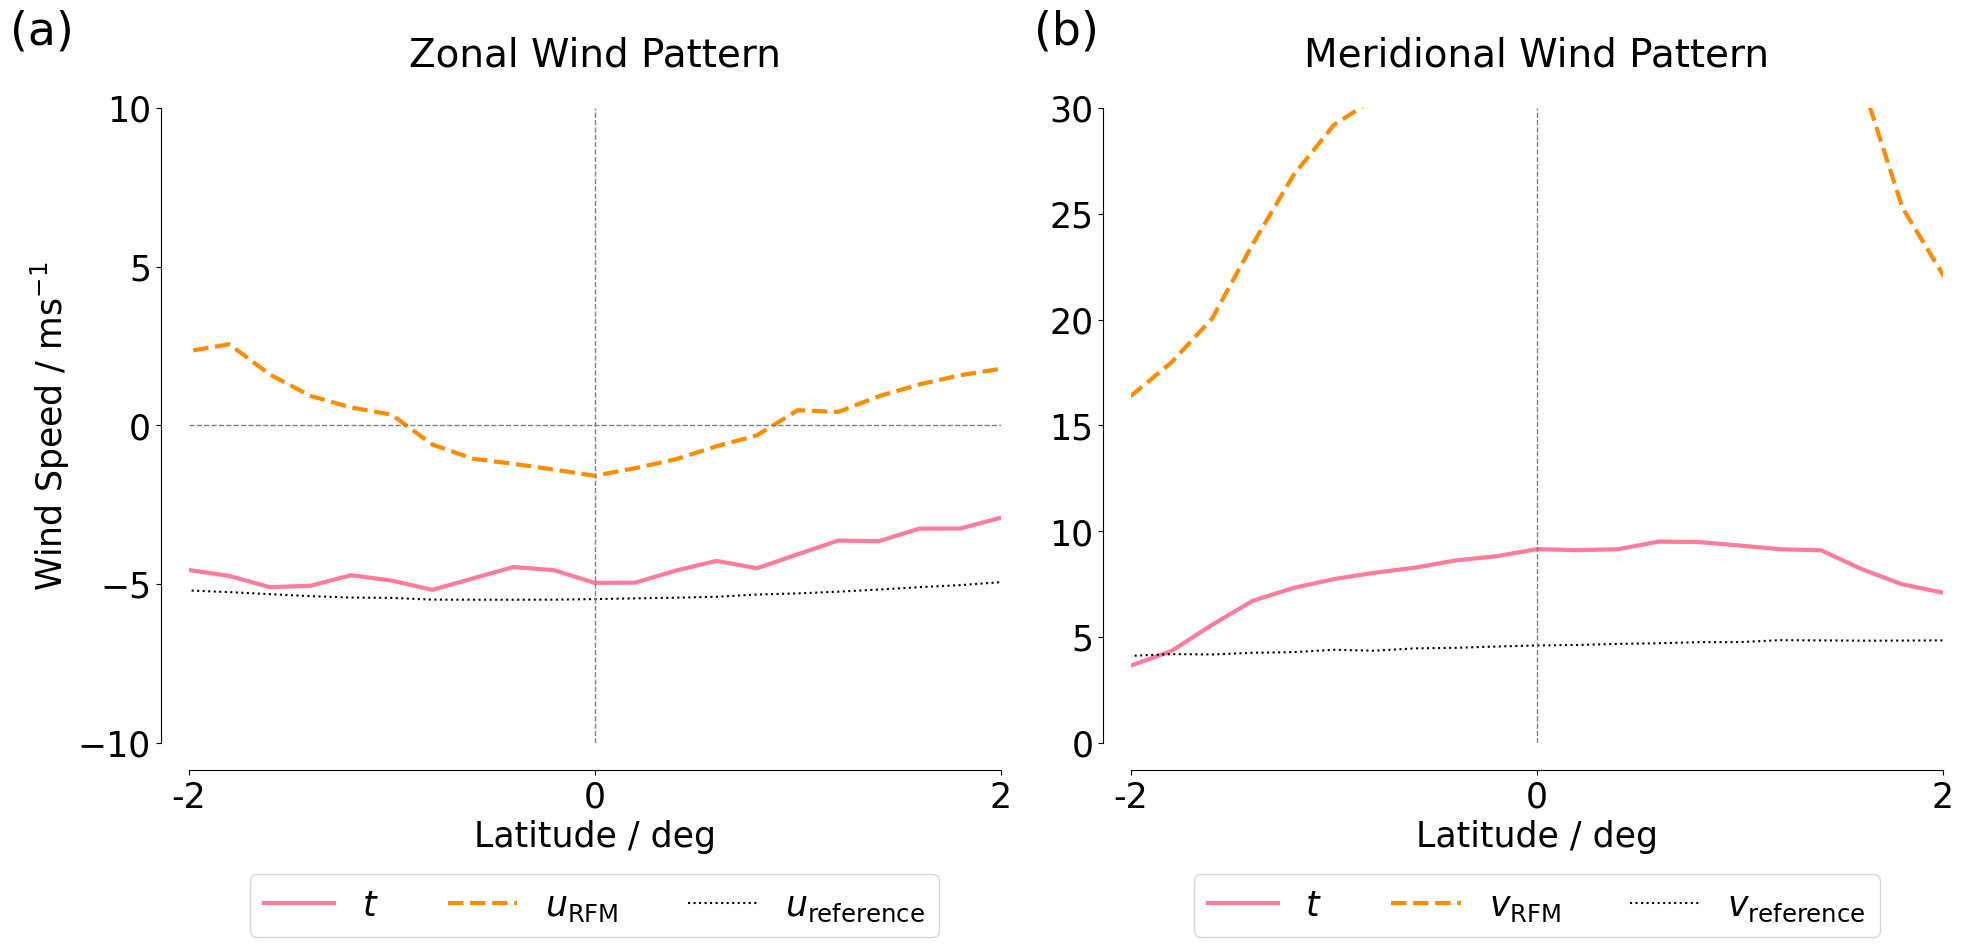

In [16]:
fig = plt.figure(figsize=(20,10), facecolor='w', edgecolor='k')

G = gridspec.GridSpec(1,2)

y_lim_min = -10
y_lim_max = 10

ax1 = plt.subplot(G[0,0])

ax1.axhline(y = 0, color = 'grey', linestyle = '--', lw=1, zorder=3)
ax1.axvline(x = ZONAL_BINS/2, color = 'grey', linestyle = '--', lw=1, zorder=3)

ax1.plot(ZM_uu_wind_revised_wpcf, color='#FF7B9C', label=r'$t$', lw=3, linestyle='solid', zorder=2)
ax1.plot(ZM_uu_RFM_wpcf, color='darkorange', label=r'$u_{\mathrm{RFM}}$', linestyle='dashed', lw=3, zorder=2, alpha=1)

ax1.plot(ZM_uu_wind_icon_orig_wpcf, label=r'$u_{\mathrm{reference}}$', color='black', linestyle='dotted', zorder=2)

ax1.set_title('Zonal Wind Pattern', fontsize=SIZE+3, pad=30)
ax1.set_xlabel('Latitude / deg')
ax1.set_ylabel(r'Wind Speed / $\mathrm{ms}^{-1}$')
ax1.set_xlim((ZONAL_BINS/2)-(0.2*ZONAL_BINS),(ZONAL_BINS/2)+(0.2*ZONAL_BINS))
ax1.set_ylim(y_lim_min,y_lim_max)
ax1.set_xticks([(ZONAL_BINS/2)-(0.2*ZONAL_BINS), ZONAL_BINS/2, (ZONAL_BINS/2)+(0.2*ZONAL_BINS)])
ax1.set_xticklabels(['-2', '0', '2'])
ax1.set_yticks([-10,-5,0,5,10])
ax1.spines[['top', 'right']].set_visible(False)
ax1.spines[['left','bottom']].set_position(('outward',20))

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), fancybox=True, shadow=False, ncol=3)

################################################
y_lim_min = 0
y_lim_max = 30
################################################

ax2 = plt.subplot(G[0,1])

#ax2.axhline(y = 0, color = 'grey', linestyle = '--', lw=1, zorder=3)
ax2.axvline(x = ZONAL_BINS/2, color = 'grey', linestyle = '--', lw=1, zorder=3)

ax2.plot(ZM_vv_wind_revised_atl, color='#FF7B9C', label=r'$t$', lw=3, linestyle='solid', zorder=2)
ax2.plot(ZM_vv_RFM_atl, color='darkorange', label=r'$v_{\mathrm{RFM}}$', linestyle='dashed', lw=3, zorder=2, alpha=1)

ax2.plot(ZM_vv_wind_icon_orig_atl, label=r'$v_{\mathrm{reference}}$', color='black', linestyle='dotted', zorder=2)

ax2.set_title('Meridional Wind Pattern', fontsize=SIZE+3, pad=30)
ax2.set_xlabel('Latitude / deg')
#ax2.set_yticks([0, 5, 10, 15, 20, ])
#ax2.set_yticklabels([])
ax2.set_xlim((ZONAL_BINS/2)-(0.2*ZONAL_BINS),(ZONAL_BINS/2)+(0.2*ZONAL_BINS))
ax2.set_ylim(y_lim_min,y_lim_max)
ax2.set_xticks([(ZONAL_BINS/2)-(0.2*ZONAL_BINS), ZONAL_BINS/2, (ZONAL_BINS/2)+(0.2*ZONAL_BINS)])
ax2.set_xticklabels(['-2', '0', '2'])
ax2.spines[['top', 'right']].set_visible(False)
ax2.spines[['left','bottom']].set_position(('outward',20))

ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), fancybox=True, shadow=False, ncol=3)

plt.tight_layout()

ax1.text(-0.22, 1.1, '(a)', fontsize=SIZE+8, transform=ax1.transAxes)
ax2.text(-0.12, 1.1, '(b)', fontsize=SIZE+8, transform=ax2.transAxes)

filename = f'fig_08_revised.pdf'
filepath = 'figs_review/'
plt.savefig(filepath + filename, facecolor='white', bbox_inches='tight', dpi=400)

plt.show()